In [30]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

sys.path.append('../../../common_code')

#Custom imports
# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd

channelColorDict_lighter = {'classic':adjust_lightness(color='#118AB2', amount=1.6),'stable B no CEE':adjust_lightness(color='orange', amount=1.4), 'immediate CE':adjust_lightness(color='#EF476F', amount=1.2),\
                            r'double-core CE':adjust_lightness(color='#073B4C', amount=1.8), 'other':adjust_lightness(color='gray', amount=1.5),  'vi':adjust_lightness(color='cyan', amount=1.5), 'vii':adjust_lightness(color='#FFD166', amount=1.2)}
channelList = ['classic', 'stable B no CEE', 'vii',  'immediate CE',  r'double-core CE', 'other'] #, 'vi']
#######

In [49]:


def create_pd_metallicity_from_xparam(DCOtype='BHNS', BPSmodelName='A', pathData='/Volumes/SimonsFoundation/DataDCO/', quantile_values=[0.5, 0.25, 0.75], xparam='log10_t_delay'):
    """
    whichplot='rate', 'ratio'
    
    """

    
    meanMassEvolved = 77708655
    totalMassEvolved = meanMassEvolved*53 # 53 = number of metallicity bins used for simulation
    
#     pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
#     redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    if DCOtype=='BBH':
        adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other']
    elif DCOtype=='BHNS':
        adjustedChannelList = ['classic', 'stable B no CEE', 'immediate CE'] #,  r'double-core CE', 'other']
    if DCOtype=='BNS':
        adjustedChannelList = ['classic',   r'double-core CE'] #, 'other']
#     adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
    print('running for channels', adjustedChannelList)
    
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    fdata = h5.File(full_data_path,'r')     # read in data 
    
#     print('running xparam:', xparam)
    
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    # make this a dictionary instead !!
    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
    elif xparam=='mass_tot':
        param_x = massCO_LVKM1 + massCO_LVKM2
    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
    elif xparam=='mass_1_LVK':
        param_x = massCO_LVKM1
    elif xparam=='mass_2_LVK':
        param_x = massCO_LVKM2
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        # WORKING HERE 
        xmin, xmax, res_bin = -3,3, 0.2
        nbins = int((xmax-xmin)/res_bin + 1) 
        xbins = np.logspace(xmin, xmax, nbins)
        
    elif xparam=='t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        xmin, xmax, res_bin = -3,3, 0.2
        nbins = int((xmax-xmin)/res_bin + 1) 
        xbins = np.logspace(xmin, xmax, int(nbins)+1)
        
        
        
    elif xparam=='M1ZAMS':
        param_x = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    elif xparam=='M2ZAMS':
        param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
    elif xparam=='qZAMS':
        param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze() / fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
    elif xparam=='separationInitial':
        param_x = fdata['doubleCompactObjects']['separationInitial'][...].squeeze()
    # get the parameter to plot of interest 
#     param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    

    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    metallicities = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    #     param_x = np.log10(param_x)
    
    
    
    fc_data = np.zeros((nbins, 1)) # create empty dataset for metallicities
    x_centers = (xbins[0:-1]+xbins[1:])/2
    fc_data[:,0] = x_centers # fill with metallicity data 
    df = pd.DataFrame(fc_data, columns=["xbin_centers"])

    for nrC, Channel in enumerate(adjustedChannelList): 
        # obtain fc_mask for the requested channel name 
        ind_wanted = dictFormationChannelIndex[Channel]
        mask_c = (channels==ind_wanted)
#         print('at Channel ', Channel)
#         for ind_q, quantile in enumerate(quantiles):
        data_to_add = np.zeros((nbins, 1))
        data_to_add[:] = 0 #$np.nan # start with nan values so that we do not plot datapoint if it doesnt exist 
        column_names = [Channel + '_xbin_rate' ] # creates array with header names 

        hist, bin_edges = np.histogram(param_x[mask_c], bins=xbins, weights=weights_[mask_c])
        bin_centers = (bin_edges[0:-1]+bin_edges[1:])/2        
        
        data_to_add[:,0] = hist*(1/bin_centers)
        #
#         data_to_add[ind_Z] = weighted_quantile(values=param_x[mask_MRR][mask_ZZ], quantiles=quantile_values, sample_weight=weights_[mask_MRR][mask_ZZ])
                
        df_to_add = pd.DataFrame(data_to_add, columns=column_names)
        df = pd.concat([df, df_to_add], axis=1)

    # always close the dataset
    fdata.close()

    return df




def plot_formation_channels_metallicity_from_xparam_for_quantiles(axe='None', DCOtype='BHNS', BPS_models_to_run_list=['A'], 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                              add_model_label=True, quantile_values=[0.5, 0.25, 0.75], xparam='log10_t_delay'):
    
#     print('running xparam:', xparam)
#     print()
    
    
    
    if DCOtype=='BBH':
        adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other']
    elif DCOtype=='BHNS':
        adjustedChannelList = ['classic', 'stable B no CEE', 'immediate CE'] #,  r'double-core CE', 'other']
    if DCOtype=='BNS':
        adjustedChannelList = ['classic',   r'double-core CE'] #, 'other']
    print('running for channels', adjustedChannelList)
#     adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']

    for ind_bps, BPSmodelName in enumerate(BPS_models_to_run_list):
        df = create_pd_metallicity_from_xparam(quantile_values=quantile_values, BPSmodelName=BPSmodelName, DCOtype=DCOtype, xparam=xparam)
        xbin_centers = df["xbin_centers"]
        
        
#         norm_classic_tdelay = df['classic q_0.5'].values
#         print('median ref time; ', norm_classic_tdelay)
        # plot the channel 
        for nrC, Channel in enumerate(adjustedChannelList): 
            c_FC = channelColorDict[Channel]
            colors_lighter_FC =  channelColorDict_lighter[Channel]

            column_name = Channel + '_xbin_rate'  # creates array with header names 
            xbin_centers_rate = df[column_name] #

            axe.scatter((xbin_centers), xbin_centers_rate, color=c_FC, marker=dictMarkerShape[BPSmodelName], s=40) #/norm_classic_tdelay
            axe.plot(   (xbin_centers), xbin_centers_rate, color=c_FC, lw=4) #, ls=linestyles_mssfrind[ind_mssfr_zind])


    
    

    xlabel = r'$rate$'
    nbins = 500
    if xparam=='chirp_mass_LVK':
        ylabel = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        xbins = np.linspace(0, 100, nbins)
#     elif xparam=='mass_tot':
#         ylabel = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
#         xbins = np.linspace(0, 200, nbins)
#     elif xparam=='mass_ratio_LVK':
#         ylabel = r'$q$'
#         xbins = np.linspace(0, 1, nbins)
#     elif xparam=='mass_1_LVK':
#         ylabel = r'$m_1 [M_{\odot}]$'
#         if DCOtype=='BBH':
#             xbins = np.linspace(0, 80, nbins)
#         elif DCOtype=='BHNS':
#             xbins = np.linspace(0, 40, nbins)
            
#     elif xparam=='mass_2_LVK':
#         ylabel = r'$m_2 [M_{\odot}]$'
#         xbins = np.linspace(0, 80, nbins)
    elif xparam=='log10_t_delay':
        ylabel = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
    elif xparam=='t_delay':
        ylabel = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'
        
#     elif xparam=='M1ZAMS':
#         ylabel = r'$\rm{M}_{\rm{ZAMS, 1}} \ [M_{\odot}]$'
#     elif xparam=='M2ZAMS':
#         ylabel = r'$\rm{M}_{\rm{ZAMS, 2}} \ [M_{\odot}]$'
#     elif xparam=='qZAMS':
#         ylabel = r'${q}_{\rm{ZAMS}} $'
#     elif xparam=='separationInitial':
#         ylabel = r'${a}_{\rm{ZAMS}} [\rm{AU}] $'      
    
#     ylabel = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'
    
    axe = layoutAxes(axe, nameX=ylabel, nameY=xlabel, setMinor=True)
    # set metallicity range
#     axe.set_xlim(-4,-1.7)
    
    if xparam in ['t_delay', 'separationInitial']:
        axe.set_yscale('log')
        axe.set_xscale('log')
    
    
#     bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
#     axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
#                  xycoords='axes fraction', fontsize = fs-6, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
#                 zorder=1E10)  
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{%s}'%(DCOtype), xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)
            
            
    return axe



at xparam  t_delay
at DCOtype = BHNS
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for channels ['classic', 'stable B no CEE', 'immediate CE']
running for

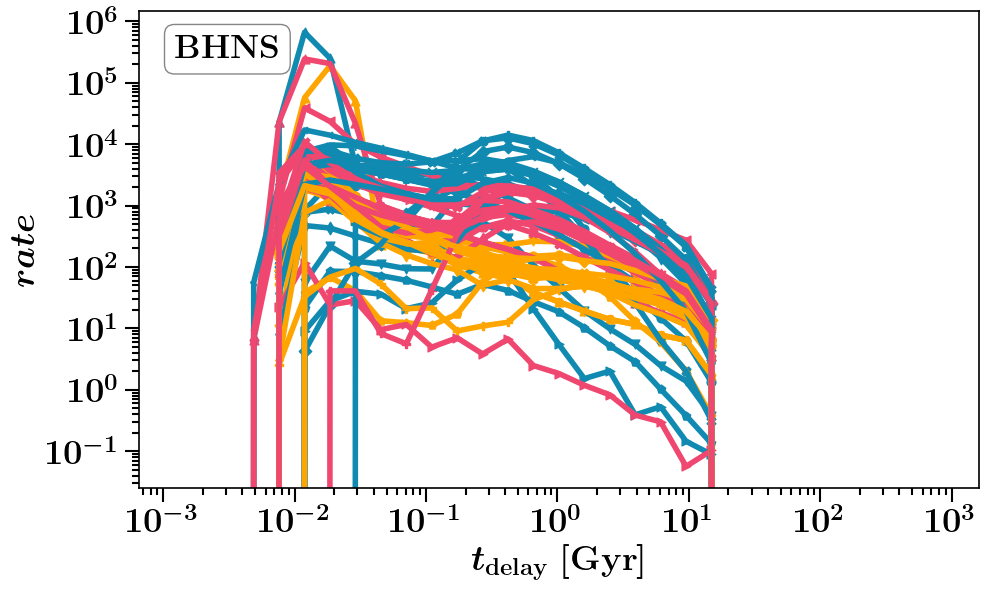


at DCOtype = BNS
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for channels ['classic', 'double-core CE']
running for c

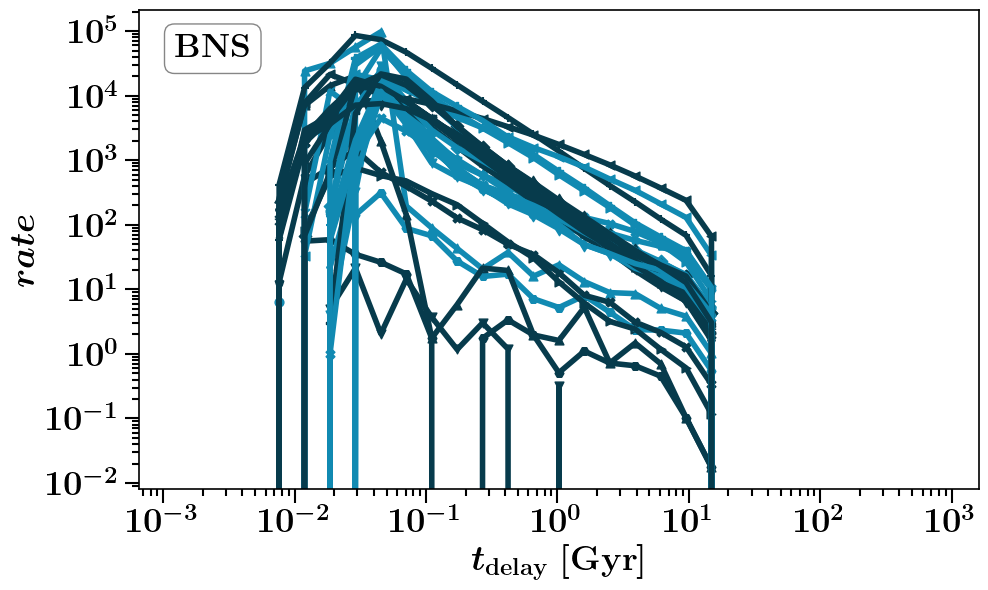

In [51]:



###
quantile_values=[0.5, 0.25, 0.75, 0.1, 0.9 ]
DCOTypeList = [ 'BHNS', 'BNS'] #'BBH'] #,
whichQuantity = 'median'
pathData='/Volumes/SimonsFoundation/DataDCO/'
###


# for xparam_wanted in [ 'mass_tot', 't_delay', 'mass_ratio_LVK', 'mass_1_LVK', 'mass_2_LVK','chirp_mass_LVK',]:
for xparam_wanted in [ 't_delay']: #, 'M1ZAMS', 'M2ZAMS']:
    print('at xparam ', xparam_wanted)
    for ind_m, BPSmodelName in  enumerate([0]):
#     for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#         print('at BPS model ', BPSmodelName)
#         BPS_models_to_run_list=[BPSmodelName]
        BPS_models_to_run_list = BPSnameslist
        for DCOtype in DCOTypeList: #'BNS', 'BHNS', 
            print('at DCOtype =', DCOtype)


            ncols, nrows= 1,1
            f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,6), 
                          gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



            ax = plot_formation_channels_metallicity_from_xparam_for_quantiles(axe=ax, DCOtype=DCOtype, BPS_models_to_run_list=BPS_models_to_run_list,\
                                                                  pathData=pathData,mask_specific_mssfr=None, whichQuantity=whichQuantity, value_for_fraction=False, \
                                                                               add_model_label=True, quantile_values=quantile_values, xparam=xparam_wanted) 





            ##  SAVE FIG  ###
            plt.tight_layout()
            plt.subplots_adjust(wspace=0., hspace=0.18)  
#             plt.savefig('./'+ xparam_wanted + '/MetallicityQuantile_' +  DCOtype + '_' + DCOtype + '_' + xparam_wanted + '.png', transparent=False, dpi=300)
            plt.savefig('./'+ xparam_wanted + '/MetallicityQuantile_' +  DCOtype + '_' + 'all' + '_' + xparam_wanted + '.png', transparent=False, dpi=300)
#             plt.savefig('./formation_median/'+ xparam + '/MetallicityQuantile_' +  DCOtype + '_' + BPSmodelName + '_' + xparam + '.pdf', transparent=True)
            plt.show()
            plt.close()
            print()



at xparam  t_delay
at BPS model  A
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


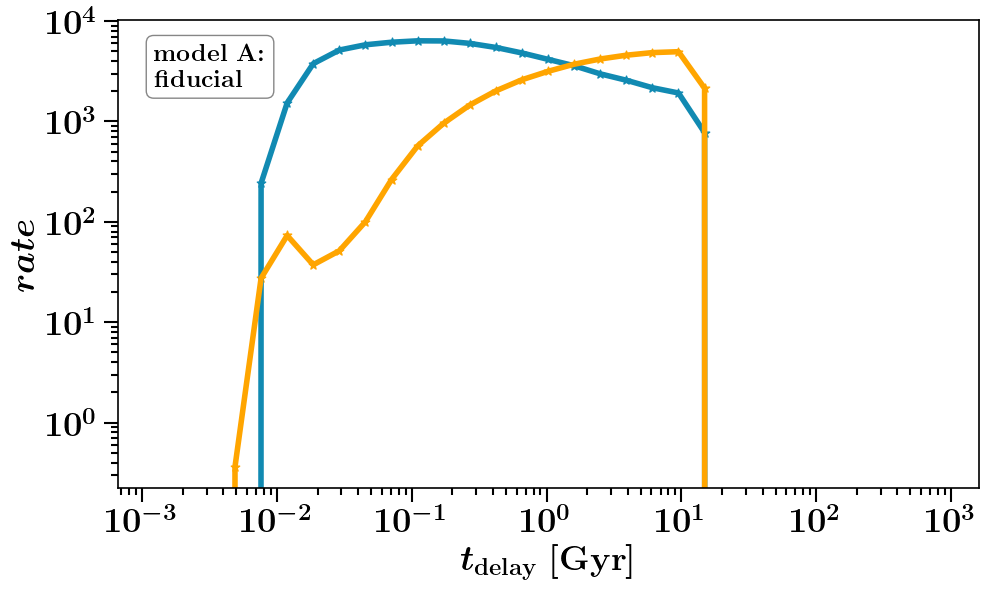


at BPS model  B
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


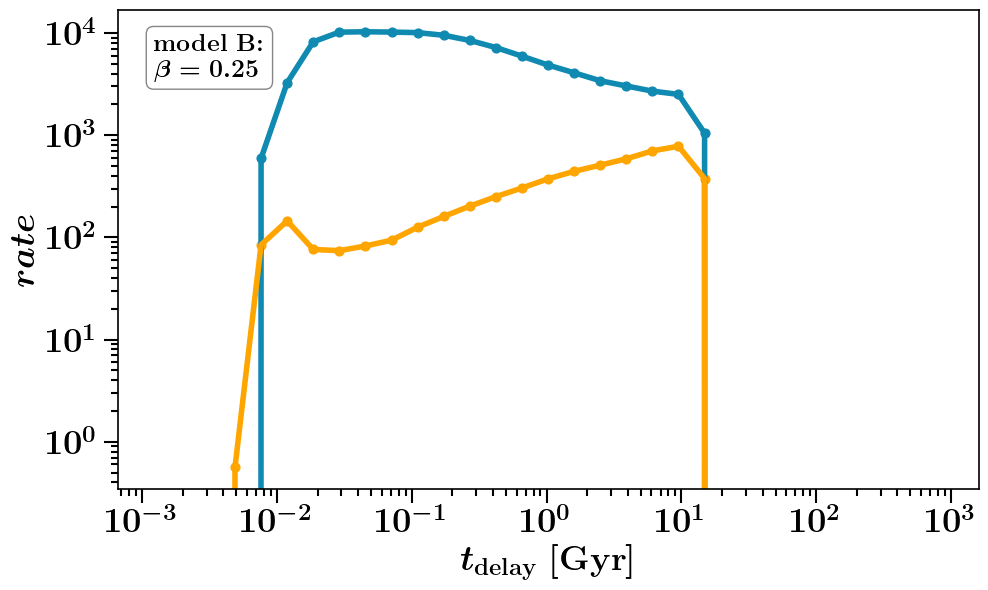


at BPS model  C
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


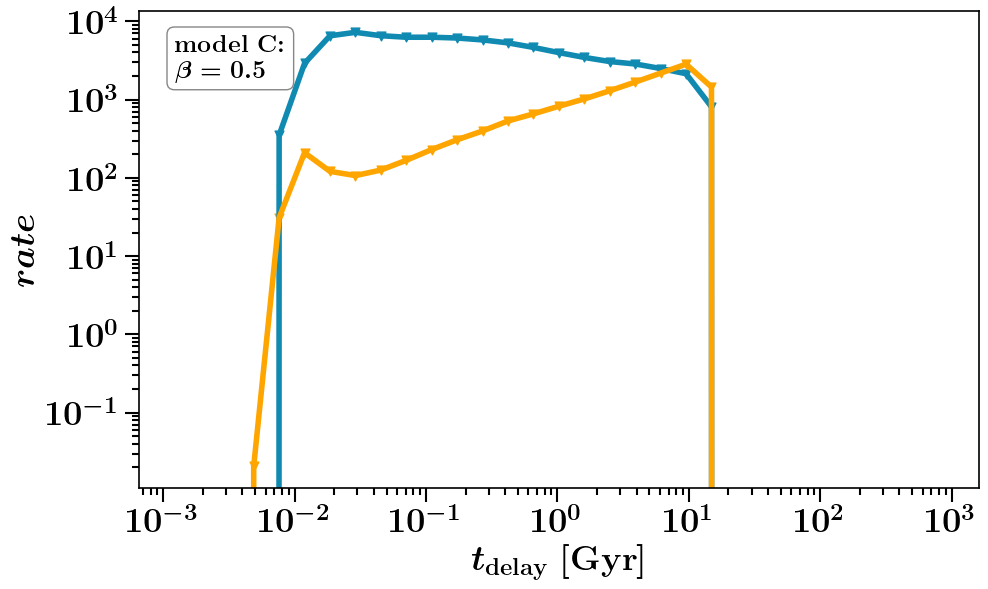


at BPS model  D
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


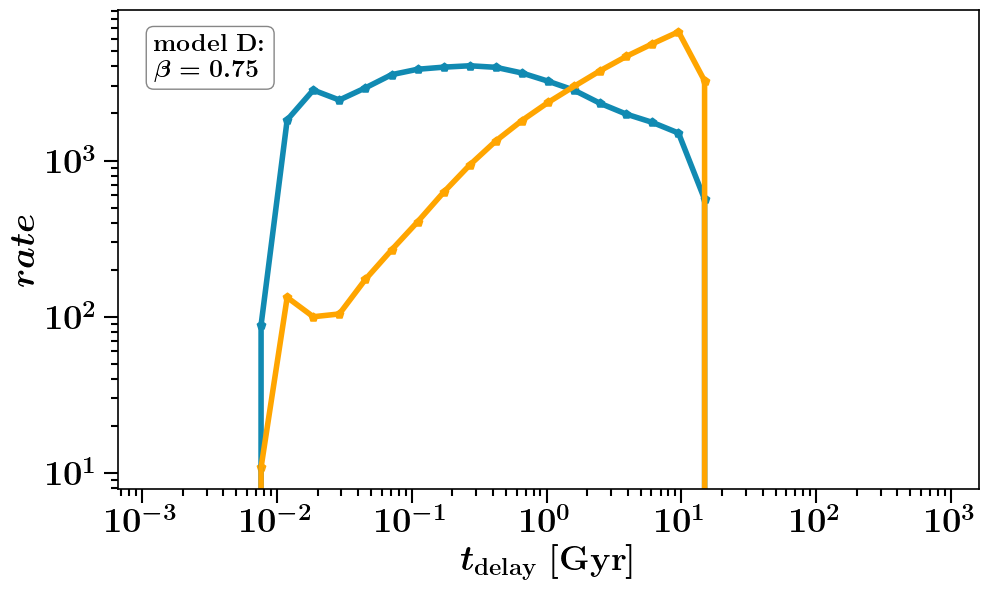


at BPS model  E
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


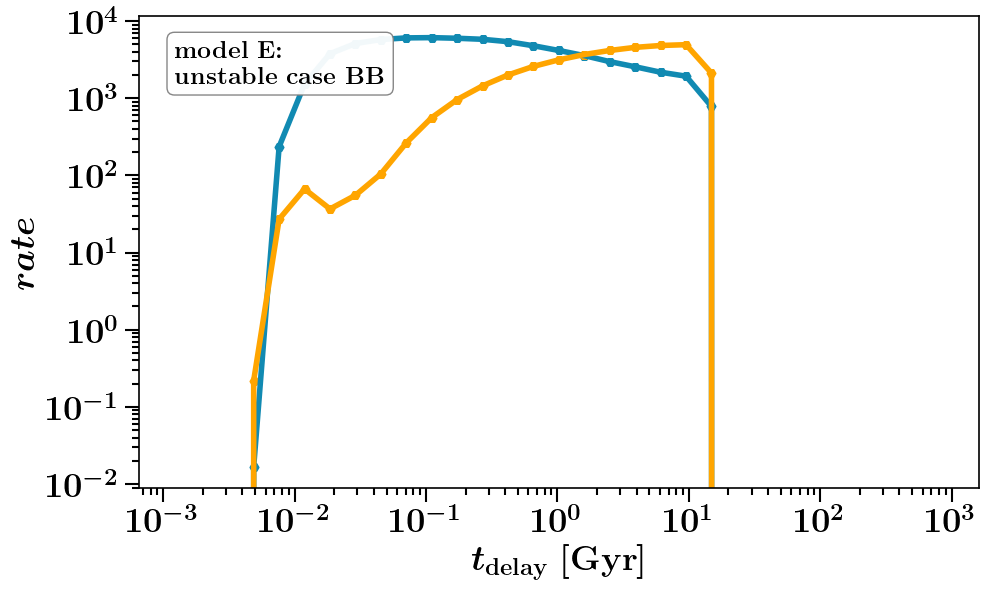


at BPS model  F
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


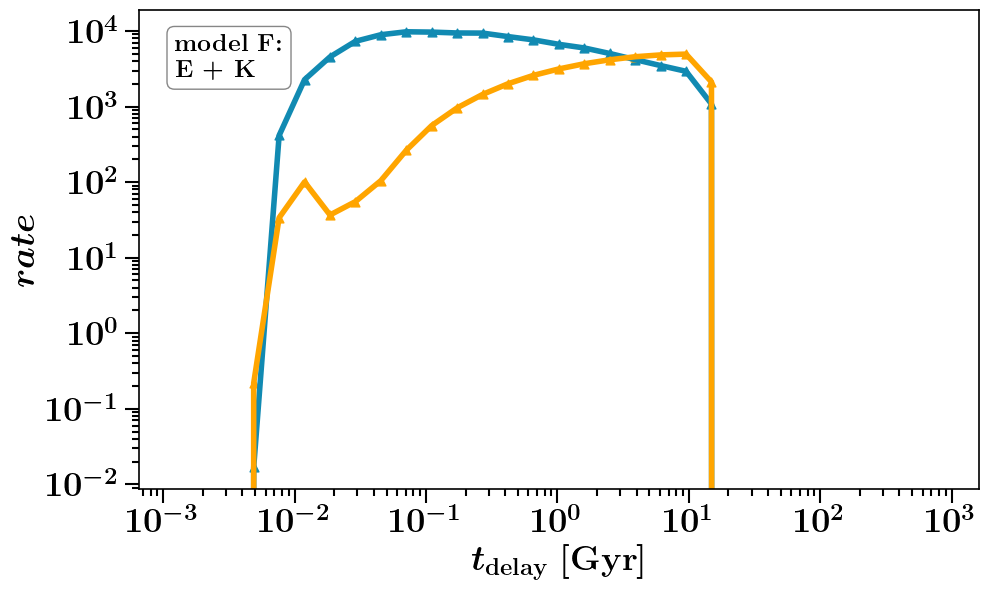


at BPS model  G
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


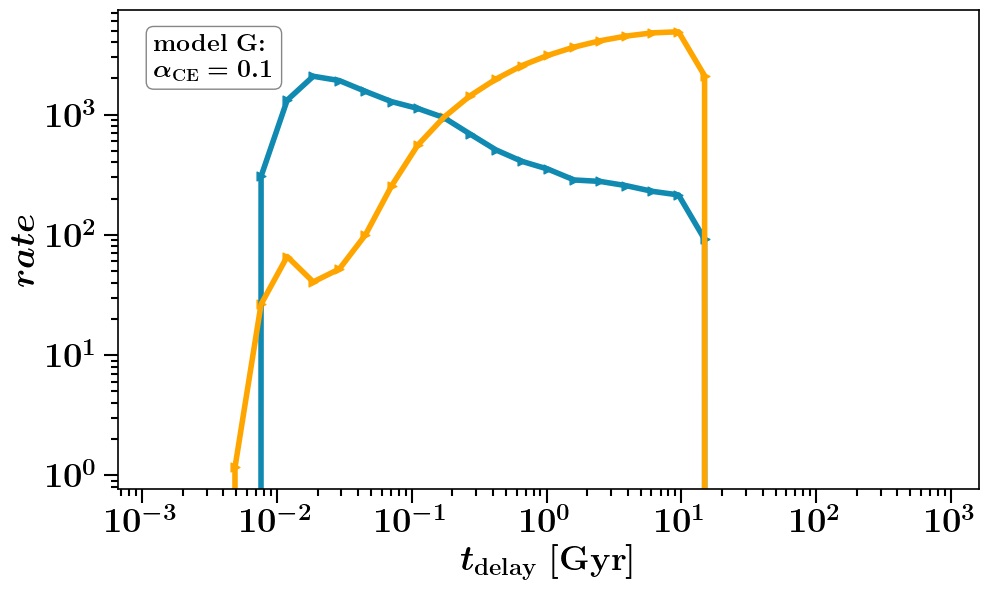


at BPS model  H
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


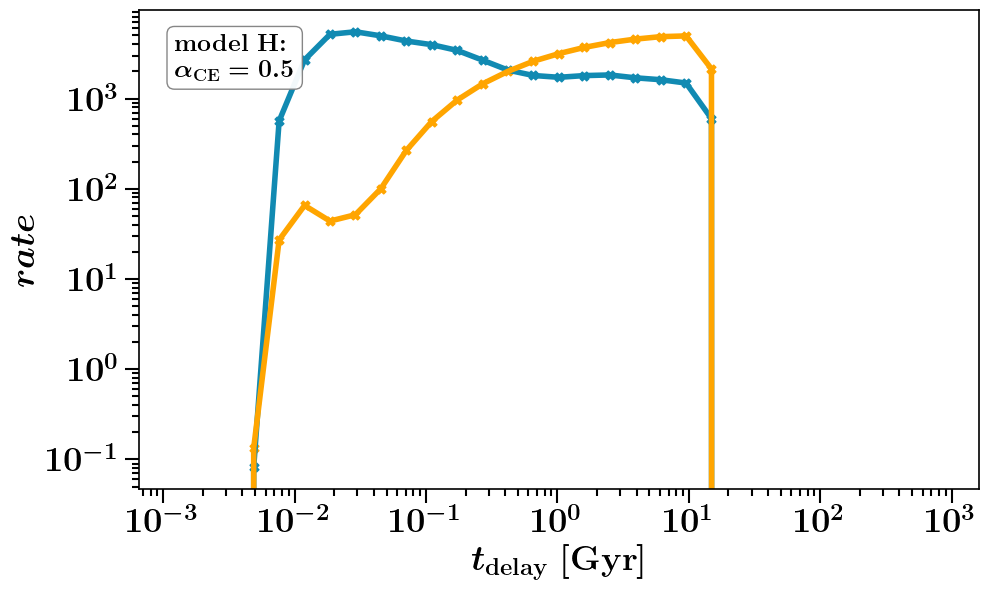


at BPS model  I
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


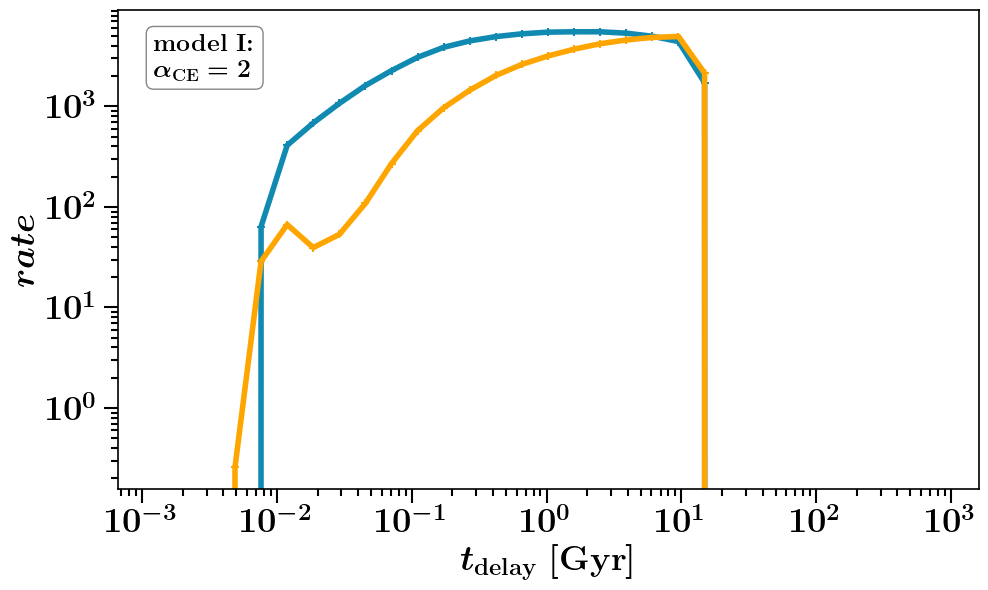


at BPS model  J
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


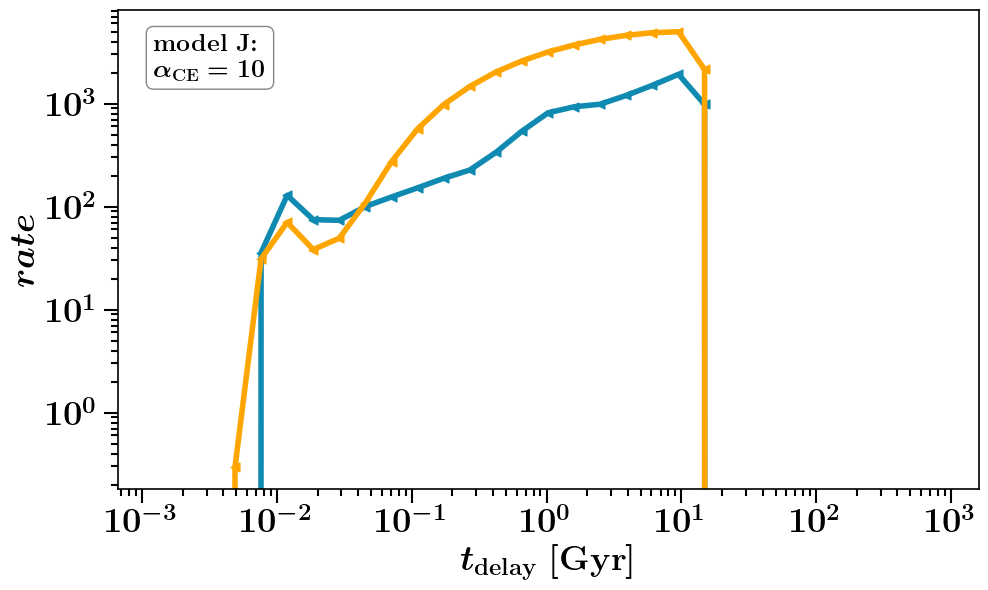


at BPS model  K
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


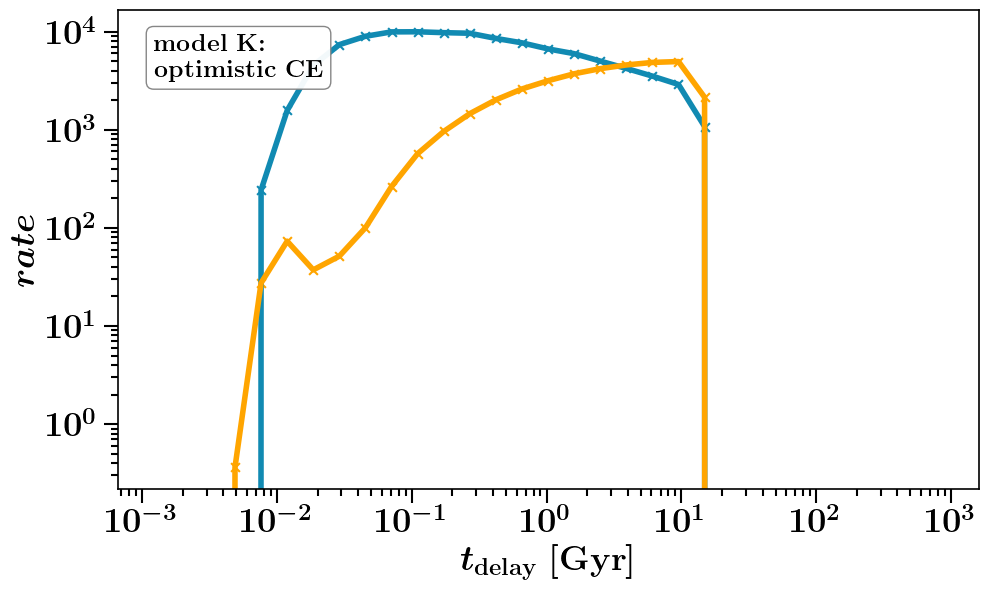


at BPS model  L
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


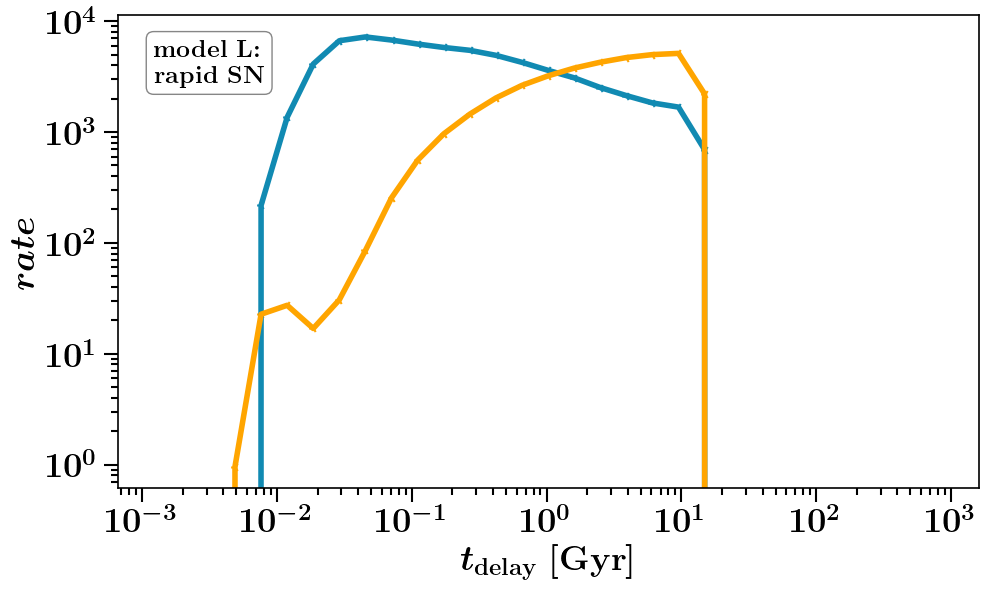


at BPS model  M
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


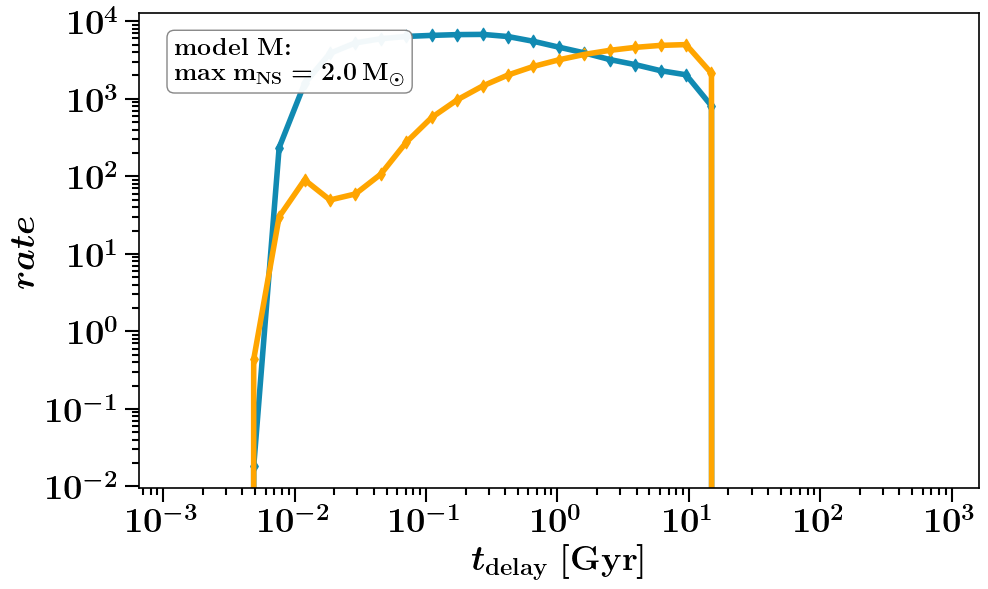


at BPS model  N
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


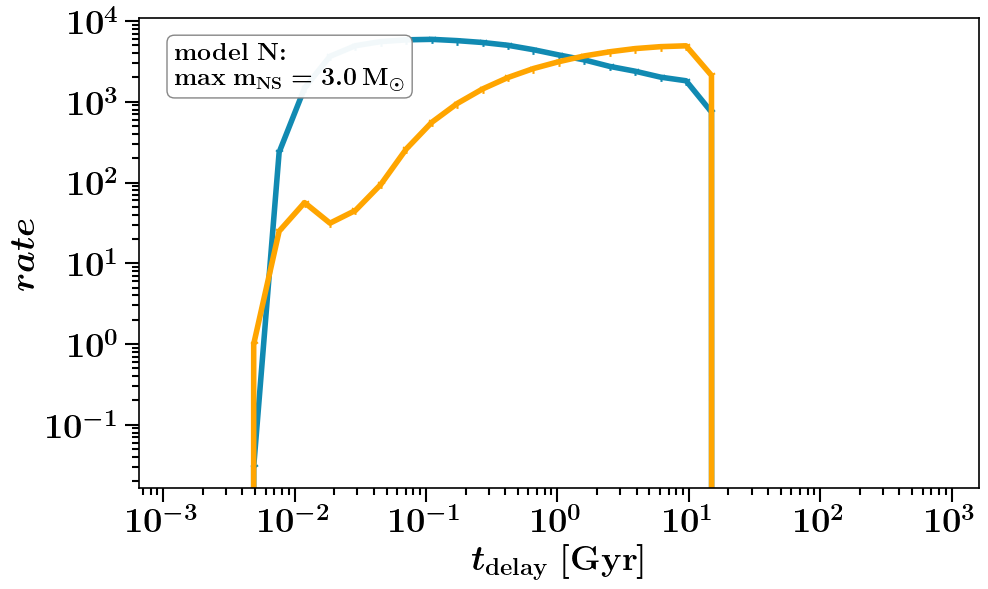


at BPS model  O
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


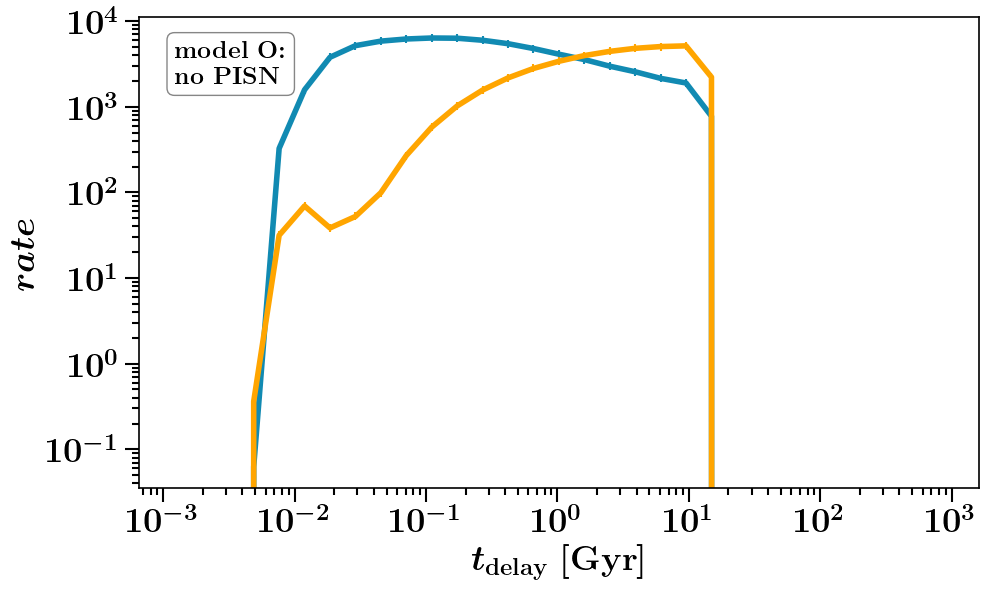


at BPS model  P
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


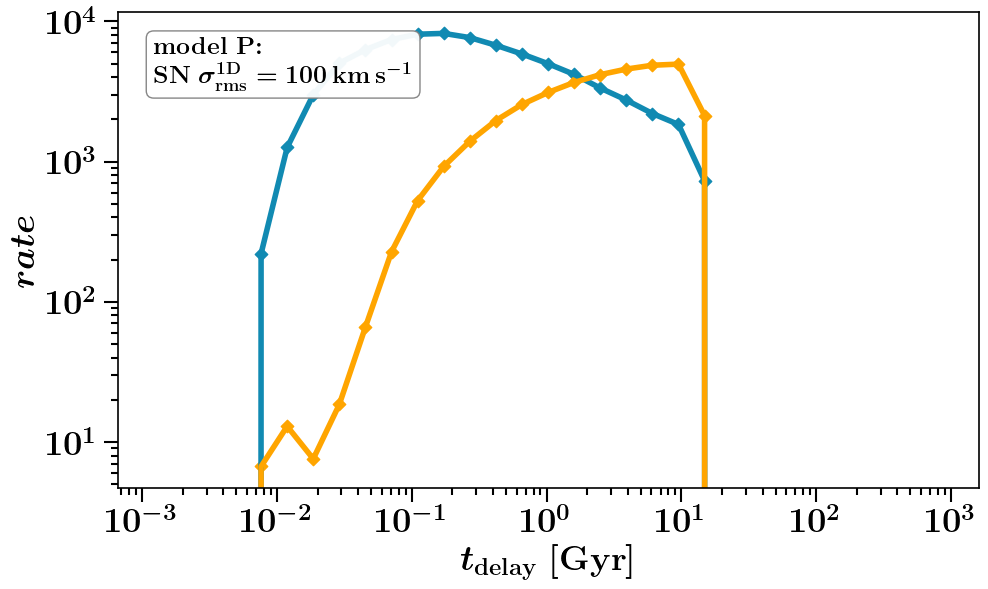


at BPS model  Q
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


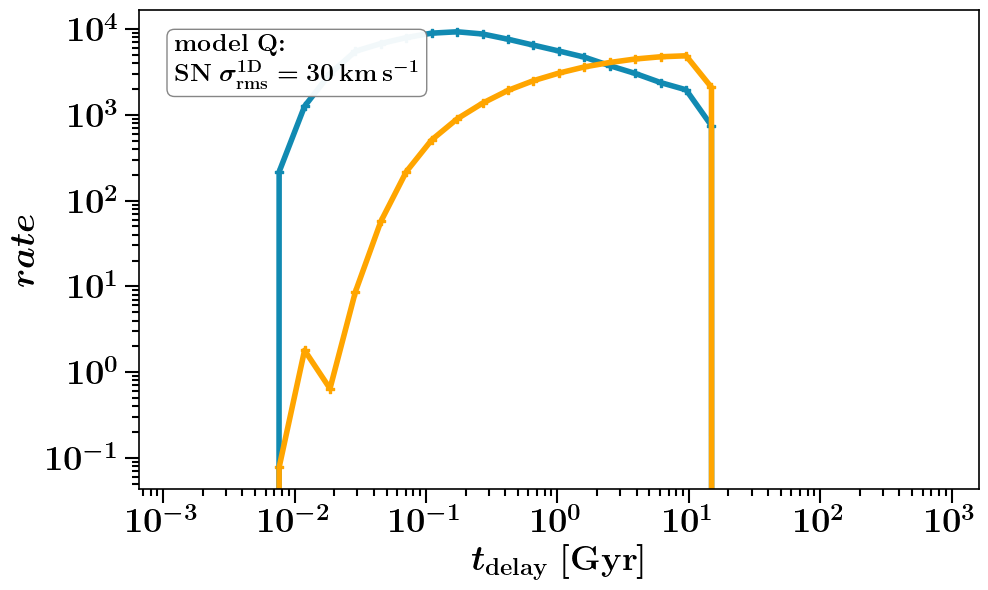


at BPS model  R
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


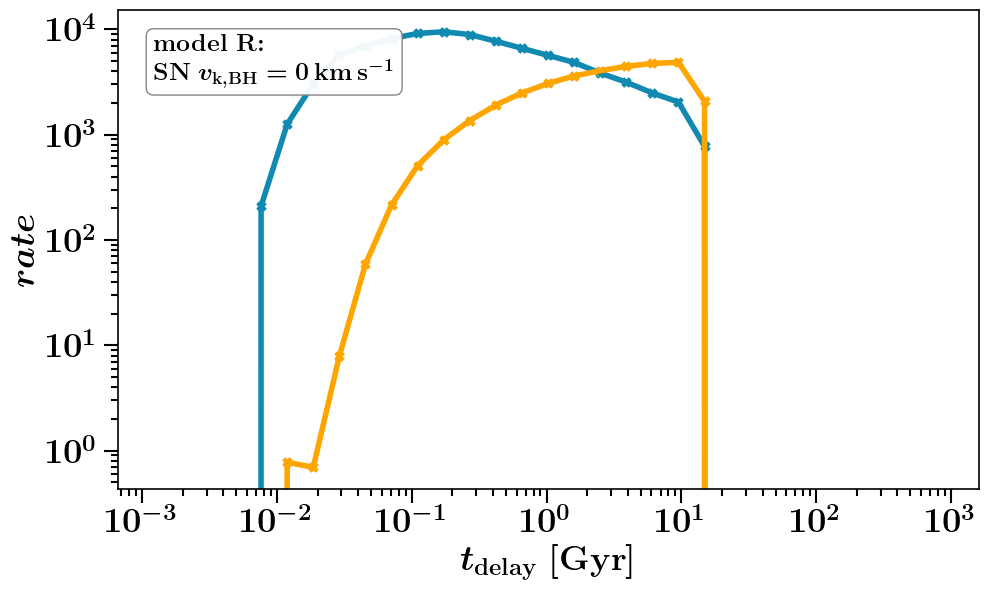


at BPS model  S
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


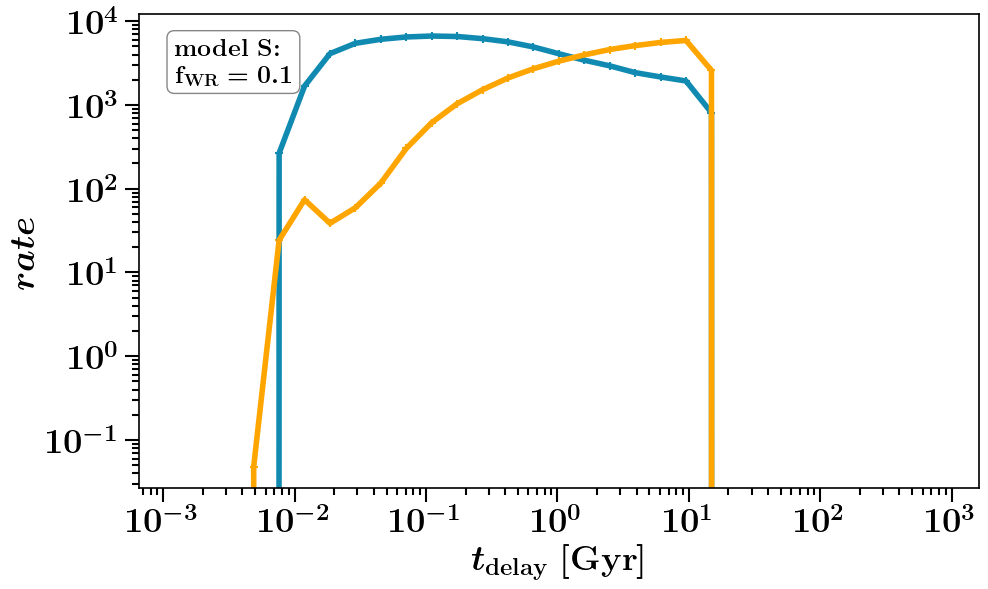


at BPS model  T
at DCOtype = BBH
running for channels ['classic', 'stable B no CEE']
running for channels ['classic', 'stable B no CEE']


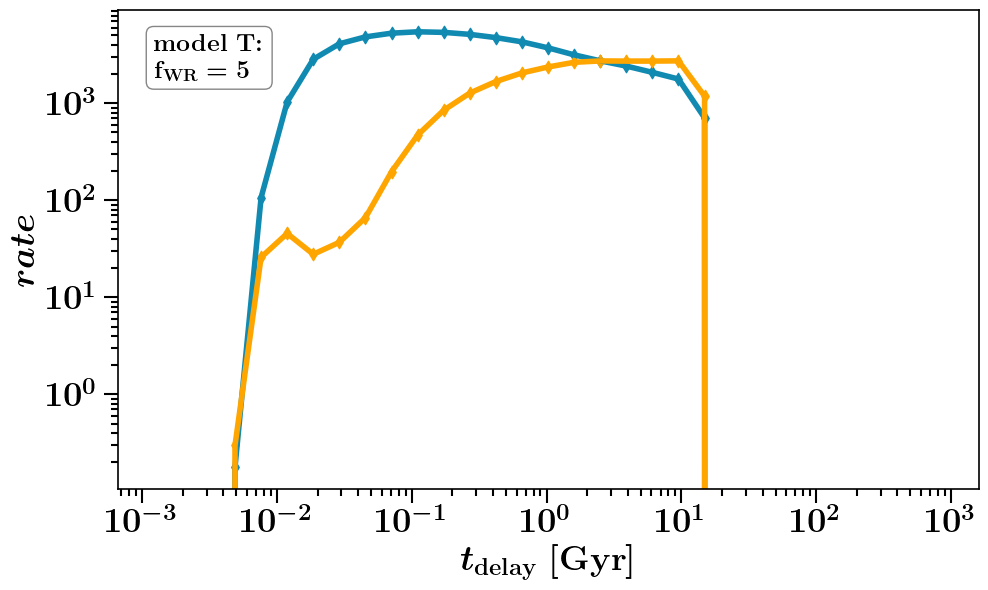

In [41]:



###
quantile_values=[0.5, 0.25, 0.75, 0.1, 0.9 ]
DCOTypeList = ['BBH'] #, 'BHNS', 'BNS']
whichQuantity = 'median'
pathData='/Volumes/SimonsFoundation/DataDCO/'
###


# for xparam_wanted in [ 'mass_tot', 't_delay', 'mass_ratio_LVK', 'mass_1_LVK', 'mass_2_LVK','chirp_mass_LVK',]:
for xparam_wanted in [ 't_delay']: #, 'M1ZAMS', 'M2ZAMS']:
    print('at xparam ', xparam_wanted)
    for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
        print('at BPS model ', BPSmodelName)
        BPS_models_to_run_list=[BPSmodelName]
    #     BPS_models_to_run_list = BPSnameslist
        for DCOtype in DCOTypeList: #'BNS', 'BHNS', 
            print('at DCOtype =', DCOtype)


            ncols, nrows= 1,1
            f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,6), 
                          gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



            ax = plot_formation_channels_metallicity_from_xparam_for_quantiles(axe=ax, DCOtype=DCOtype, BPS_models_to_run_list=BPS_models_to_run_list,\
                                                                  pathData=pathData,mask_specific_mssfr=None, whichQuantity=whichQuantity, value_for_fraction=False, \
                                                                               add_model_label=True, quantile_values=quantile_values, xparam=xparam_wanted) 





            ##  SAVE FIG  ###
            plt.tight_layout()
            plt.subplots_adjust(wspace=0., hspace=0.18)  
            plt.savefig('./'+ xparam_wanted + '/MetallicityQuantile_' +  DCOtype + '_' + BPSmodelName + '_' + xparam_wanted + '.png', transparent=False, dpi=300)
#             plt.savefig('./formation_median/'+ xparam + '/MetallicityQuantile_' +  DCOtype + '_' + BPSmodelName + '_' + xparam + '.pdf', transparent=True)
            plt.show()
            plt.close()
            print()

